# Demodulation: accuracy analysis

In [5]:
### define your functions here:

def myfunc():
    return


## Installation of the **'numpy'** library from a Jupyter notebook
It is not recommended to use:
    pip install numpy
    
although, it can work. Check the following link for an explanation:    
[Link to source explaining this method](http://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/index.html)

"...in summary, the reason that installation of packages in the Jupyter notebook is fraught with difficulty is fundamentally that Jupyter's shell environment and Python kernel are mismatched, and that means that you have to do more than simply pip install or conda install to make things work. The exception is the special case where you run jupyter notebook from the same Python environment to which your kernel points; in that case the simple installation approach should work."

In [540]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install numfi


## Installation of the **'matplotlib'** library from a Jupyter notebook

In [23]:
import sys
!{sys.executable} -m pip install matplotlib

## Define the absorption process based in the Beer-Lambert law

The gas absorbance **$A$** is equal to:
    $A = \epsilon · c · L$
    
with $\epsilon$ : molar attenuation coefficient for CO<sub>2</sub> = 0.003 [$m^-1·ppm^-1$], at 4.2 - 4.35 $\mu$m (average value, is a function of the wavelength)

with $c$ : CO<sub>2</sub> concentration level [$ppm$]        

and $L$ : length of the optical path = 0.01 [$m$]
    
Also, $\alpha = \epsilon · c$, the absorption coefficient for CO<sub>2</sub> 

In [211]:
def transmission_ratio (CO2ppm):

    ## CO2ppm_fresh_air = 400 ppm
    molar_attenuation_coeff = 0.003; 
    optical_path = 0.01;

    ## Beer-Lambert law
    absorbance = molar_attenuation_coeff * CO2ppm * optical_path; ## no units    
    return math.exp(-1 * absorbance);

# Test the absorption function

<IPython.core.display.Javascript object>


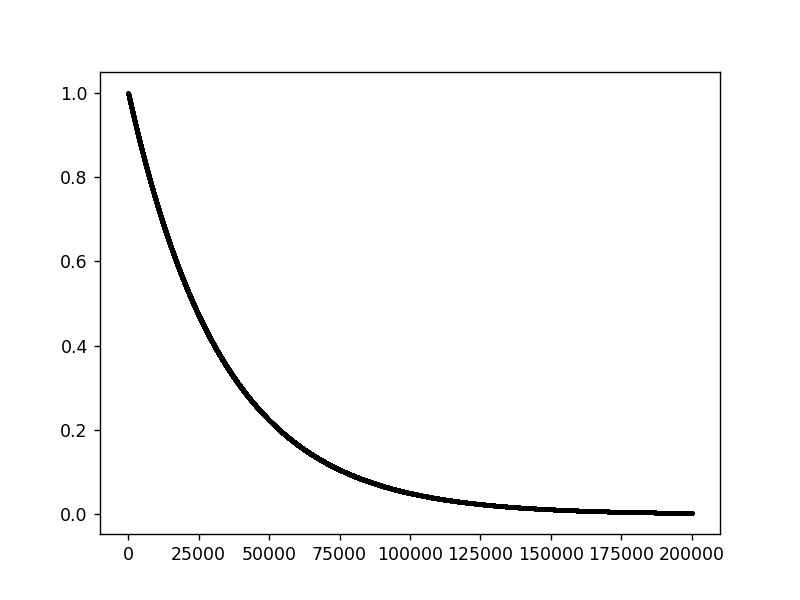

In [391]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

CO2_full_scale = 200000
input_power = 1
CO2ppm = np.arange(CO2_full_scale)
output_power = np.arange(CO2_full_scale, dtype=float)

for x in range(0, CO2_full_scale):
    output_power[x] = transmission_ratio(x) * input_power

plt.plot(CO2ppm,output_power,'ko', markersize=1)
plt.show()


# Create modulation waveform and store it as a numpy array

<IPython.core.display.Javascript object>


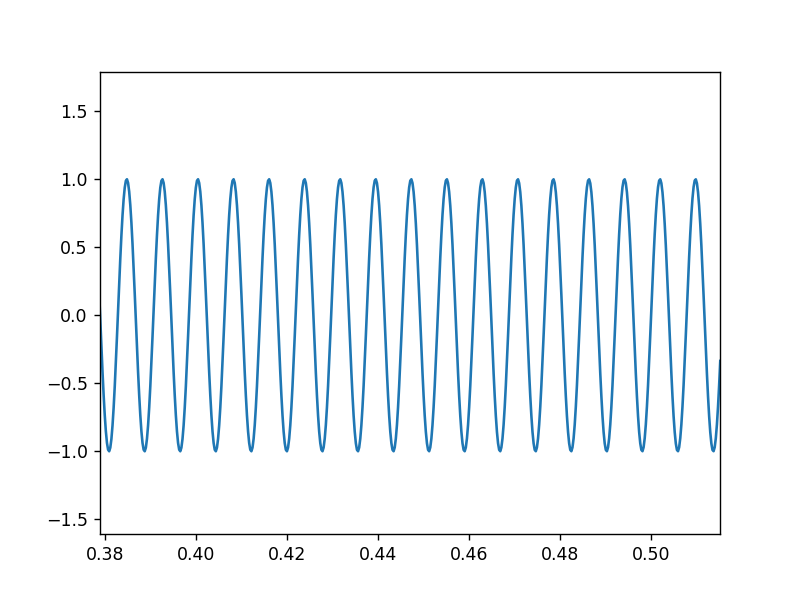

In [392]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

### MODULATION waveform

modulation_freq = 128                 ## units in [Hz]
modulation_amp = 1
modulation_points = 32

start_time = 0
stop_time = 2                       ## units in [s]
num_samples = modulation_freq * modulation_points * stop_time
time_points = np.linspace(start_time, stop_time, num_samples)

modulation_sinewave = modulation_amp * np.sin(2*math.pi*modulation_freq*time_points)

#plt.plot(time_points,modulation_sinewave,'ko', markersize=2)
plt.plot(time_points,modulation_sinewave)
plt.show()

# Additive white gaussian noise (AWGN)
Generation of AWGN for a given SNR

<IPython.core.display.Javascript object>


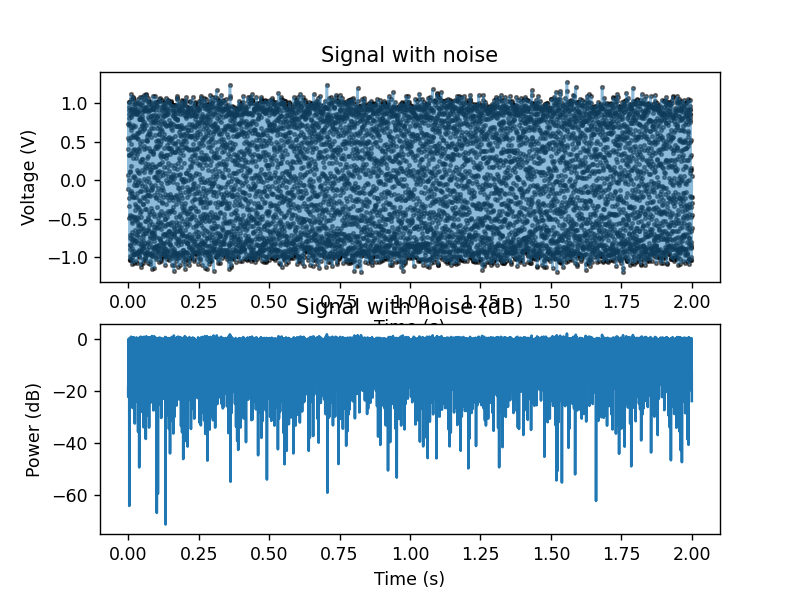

In [400]:
# Adding noise using target SNR
# Set a target SNR
%matplotlib notebook
target_snr_db = 20
CO2ppm = 400

modulation_freq = 128
modulation_points = 32
mod_source_amp = 1



start_time = 0
stop_time = 2                       ## units in [s]
num_samples = modulation_freq*modulation_points*stop_time
time_points = np.linspace(start_time, stop_time, num_samples)


# Modulated source output
mod_source_signal = mod_source_amp * np.sin(2*np.pi*modulation_freq*time_points)
x_watts = mod_source_signal ** 2

# Source output transmitted trough the channel (reaching the detector)
trans_signal = transmission_ratio(CO2ppm) * mod_source_signal


# Calculate signal power and convert to dB 
sig_avg_watts = np.mean(x_watts)
sig_avg_db = 10 * np.log10(sig_avg_watts)

# Calculate noise according to [2] then convert to watts
noise_avg_db = sig_avg_db - target_snr_db
noise_avg_watts = 10 ** (noise_avg_db / 10)

# Generate an sample of white noise
mean_noise = 0
noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(x_watts))

# Noise up the original signal
mod_noisy_signal = mod_source_signal + noise_volts
trans_noisy_signal = trans_signal + noise_volts

# Plot signal with noise
plt.subplot(2,1,1)
plt.plot(time_points, mod_noisy_signal, 'ko', markersize=2, alpha=0.5)
plt.plot(time_points, trans_noisy_signal, alpha=0.5)
plt.title('Signal with noise')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')
plt.show()

# Plot in dB
y_watts = mod_noisy_signal ** 2
y_db = 10 * np.log10(y_watts)
plt.subplot(2,1,2)
plt.plot(time_points, 10* np.log10(mod_noisy_signal**2))
plt.title('Signal with noise (dB)')
plt.ylabel('Power (dB)')
plt.xlabel('Time (s)')
plt.show()

# Demodulation


<IPython.core.display.Javascript object>


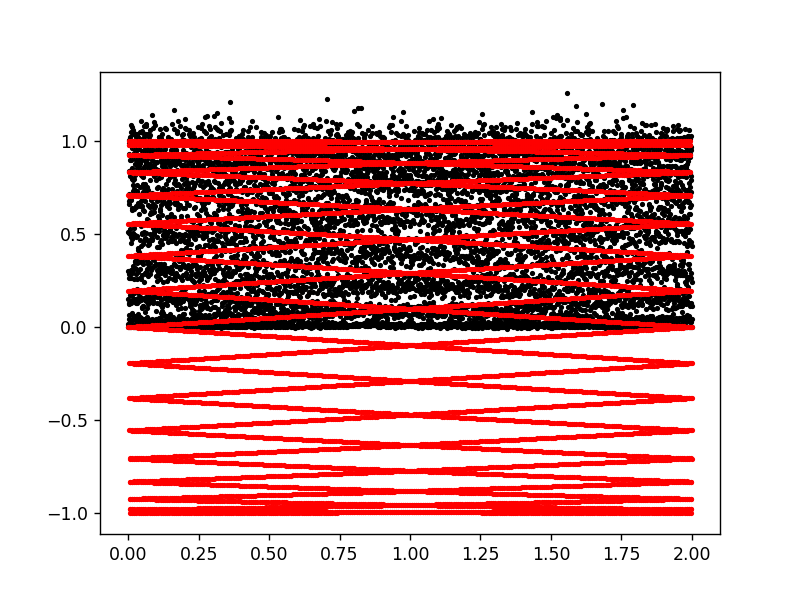

Measured value (no units):  4046.813835794095


In [401]:
# Demodulation of the signal reaching the detector

# mod_sinewave is the modulation signal
# trans_noisy_signal is the signal reaching the detector (interacting with the CO2 gas and with added noise)
%matplotlib notebook

# 1st Stage: MIXER
mix_signal = modulation_sinewave * trans_noisy_signal

plt.plot(time_points, mix_signal, 'ko', markersize=2)
plt.plot(time_points, modulation_sinewave, 'ro', markersize=2)
plt.show()

# 2nd Stage: LPF (FIR filter with unitary coeffs)
measured_val = np.sum(mix_signal)
print("Measured value (no units): ",measured_val)


# Accuracy analysis for a single CO2 value

In [402]:
# Regression for a single CO2 concentration value
molar_attenuation_coeff = 0.003; 
optical_path = 0.01;

ZeroPPM_val = np.sum(modulation_sinewave * mod_source_signal) # value @0 ppm CO2

estimatedCO2 = np.log(measured_val/ZeroPPM_val)/(-1 * molar_attenuation_coeff * optical_path)
print("Expected value: ", CO2ppm, " [ppm]")
print("Measured value: ",estimatedCO2, " [ppm]")
error = CO2ppm - estimatedCO2 
errorPCTLval = error * 100 / CO2ppm

print("ERROR %: ", round(errorPCTLval,2))


Expected value:  400  [ppm]
Measured value:  398.6315227640039  [ppm]
ERROR %:  0.34


# Accuracy analysis for a CO2 concentration range (400 - 5000 ppm)

<IPython.core.display.Javascript object>


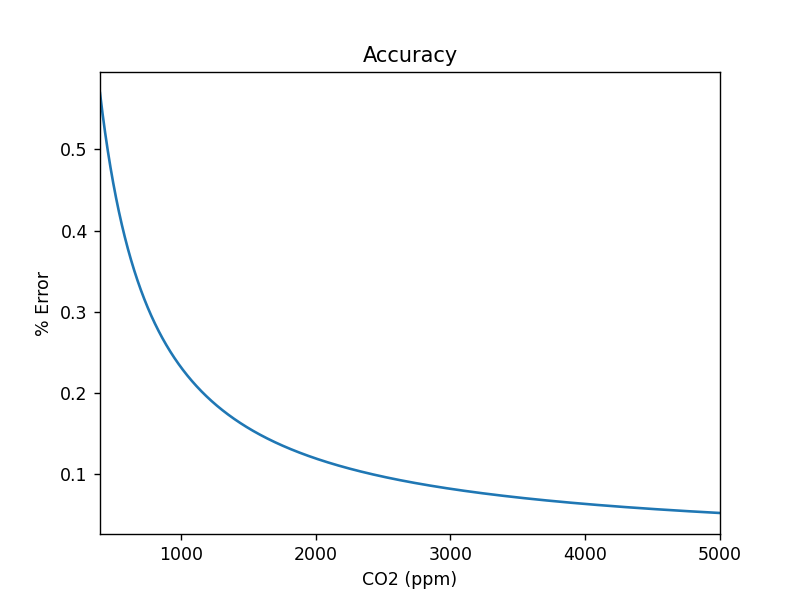

ERROR MEAN:  0.13
ERROR STDDEV:  0.1


In [538]:
# Regression for all the CO2 concentration range (400 to 5000 ppm)
%matplotlib notebook

molar_attenuation_coeff = 0.003; # [m^-1][ppm^-1]
optical_path = 0.01; # in [m]

target_snr_db = 40
modulation_freq = 128
modulation_points = 32
modulation_amp = 1
mod_source_amp = 1

CO2lower = 400
CO2upper = 5000
CO2span = CO2upper - CO2lower + 1
CO2val = np.linspace(CO2lower, CO2upper, CO2span)
errorPCTL = np.zeros(CO2span, dtype=float)

start_time = 0
stop_time = 2                       ## units in [s]
num_samples = modulation_freq * modulation_points * stop_time
time_points = np.linspace(start_time, stop_time, num_samples)

# Modulated source output
mod_source_signal = mod_source_amp * np.sin(2*np.pi*modulation_freq*time_points)
x_watts = mod_source_signal ** 2

modulation_sinewave = modulation_amp * np.sin(2*np.pi*modulation_freq*time_points)
ZeroPPM_val = np.sum(modulation_sinewave * mod_source_signal) # value @0 ppm CO2


# Calculate signal power and convert to dB 
sig_avg_watts = np.mean(x_watts)
sig_avg_db = 10 * np.log10(sig_avg_watts)

# Calculate noise according to [2] then convert to watts
noise_avg_db = sig_avg_db - target_snr_db
noise_avg_watts = 10 ** (noise_avg_db / 10)

# Generate a sample of white noise
mean_noise = 0
#noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(x_watts))
noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(mod_source_signal))


for x in range (0, CO2span): 
    # Source output transmitted trough the channel (reaching the detector)
    trans_signal = transmission_ratio(CO2val[x]) * mod_source_signal
    
    # Noise up the original signal    
    trans_noisy_signal = trans_signal + noise_volts

    # 1st Stage: MIXER
    mix_signal = modulation_sinewave * trans_noisy_signal
    
    # 2nd Stage: LPF (FIR filter with unitary coeffs)
    measured_val = np.sum(mix_signal)
    
    # Error estimation
    estimatedCO2 = np.log(measured_val/ZeroPPM_val)/(-1 * molar_attenuation_coeff * optical_path)
    error = CO2val[x] - estimatedCO2 
    errorPCTL[x] = error * 100 / CO2val[x]
    #print("CO2 level: ", CO2val[x]," [ppm]      Estimated : ", round(estimatedCO2,2),"   ERROR%: ", round(errorPCTL[x],2))
    
    
plt.xlim([CO2lower, CO2upper])
plt.title('Accuracy')
plt.ylabel('% Error')
plt.xlabel('CO2 (ppm)')
plt.plot(CO2val, errorPCTL)
plt.show()

mean = np.mean(errorPCTL)
stddev = np.std(errorPCTL)
#print(errorPCTL)
print("ERROR MEAN: ", round(mean,2))
print("ERROR STDDEV: ", round(stddev,2))


In [548]:
from numfi import numfi
x = numfi(3.1415926,1,8,5)
x

numfi([3.15625]) s8/5-r/s